In [55]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set()

In [56]:
##### obtain data #####
data = pd.read_csv('cardio_train.csv')
data.head() # age is given in days, not years, can change that later if needed 

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [57]:
 print(len(data)) # 70k samples should help w cross validation

70000


In [58]:
##### Begin analyzing and cleaning data #####
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [59]:
# inspect data to see if any issues are present
data.describe() # also gives convenient access to significant measures for each category such as mean, std, etc.
# transpose for easier view of measurements
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


In [60]:
# avg age is approx. 53 yrs w std 6.75 yrs, youngest person is ~29 ** objective
# gender is categorical 1 & 2, women and men, respectively ** objective
# height in cm ** objective
# weight in kg ***** min weight is 10 kg???? ***** ** objective
# ap_hi == Systolic blood pressure ***** minimum systolic of -150 doesn't make sense, negatives shouldn't be present ***** **examined
# ap_lo == Diastolic blood pressure ***** minimum of -70 also doesn't fit, negatives shouldn't be present ***** ** examined
# cholesterol ranges btwn 1, 2, and 3 meaning normal, above normal, and well above normal, respectively ** examined
# glucose measured same as chol above ^^^ ** examined
# smoke is binary, whether patient smokes or not ** subjective (patient report)
# alco is binary, drinks or not ** subjective
# active is binary ** subjective
# cardio is binary, has heart disease or not

# inspect data more to figure out what points are off and use histograms to find out how to replace invalid values
data_copy = data.copy(deep=True)
np.sort(data_copy['ap_hi']) # jumps from 24 to 60, make 60 bottom cutoff; at top, jumps from 240 to 309, make 240 upper cutoff
np.sort(data_copy['ap_lo']) # at top end, goes from 190 to 585, make 190 upper cutoff; make 30 lower cutoff since below 40 is considered dangerously low
np.sort(data_copy['weight']) # probably cutoff weight at 40 bottom, don't think it's realistic to have patients weighing in at less than 90 lbs, leave top alone, prob just outliers or misrecorded data

array([ 10.,  11.,  21., ..., 183., 200., 200.])

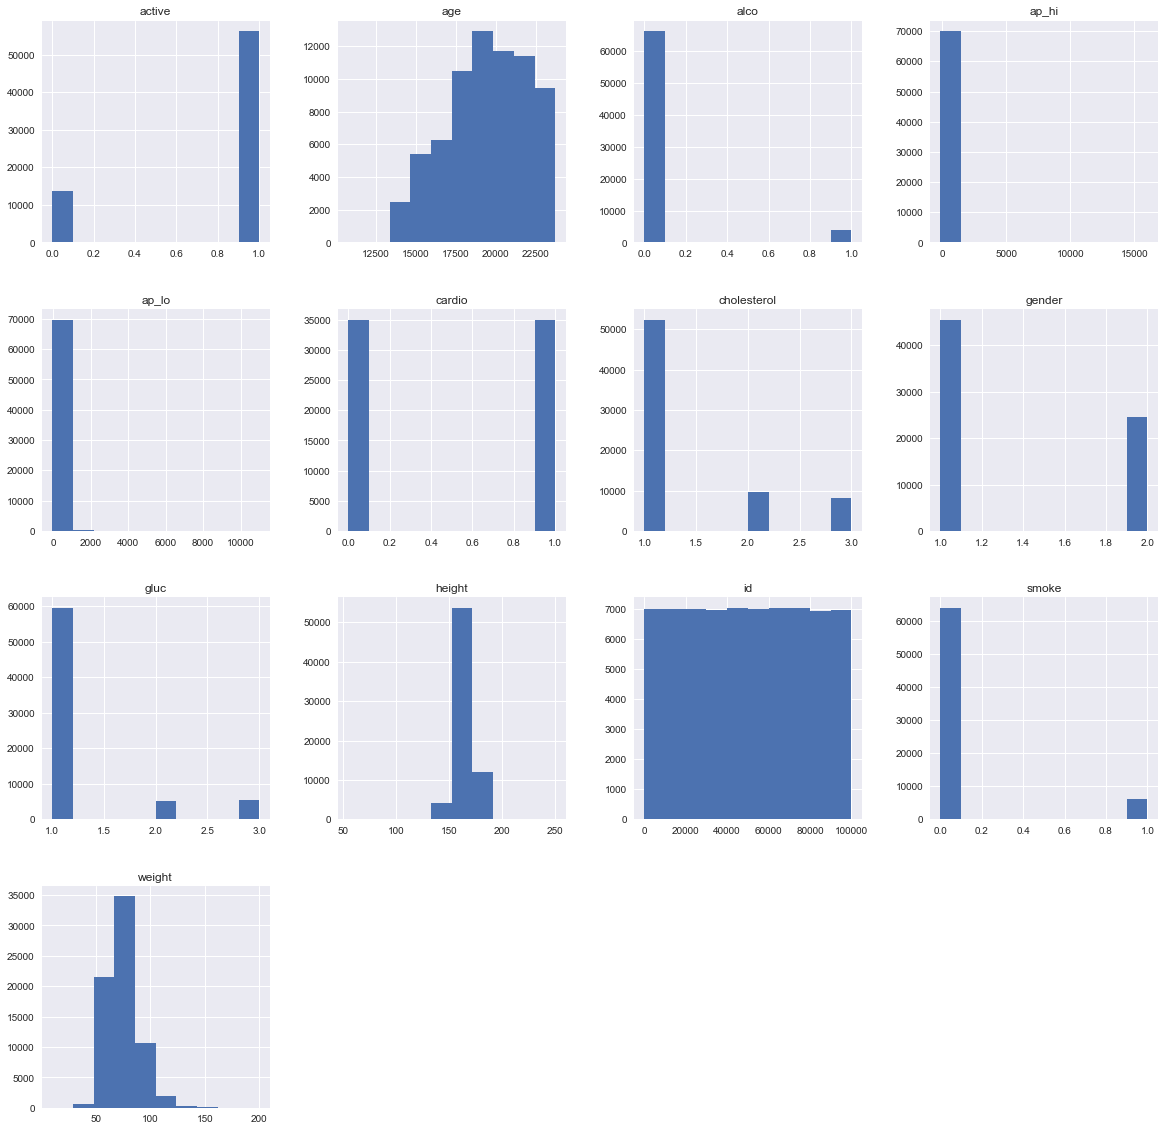

In [61]:
# histogram of each data type to understand data better
p = data_copy.hist(figsize = (20,20))

120.0 128.8172857142857
126.97901428571429 120.0


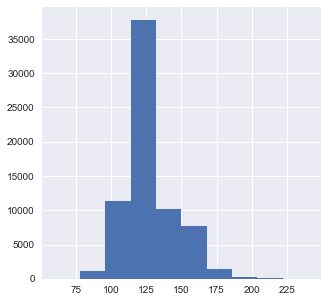

In [62]:
# ap_hi is positively skewed, replace invalid values with the median
hi_mean = np.mean(data_copy['ap_hi'])
hi_med = np.median(data_copy['ap_hi'])
print(hi_med, hi_mean)
# median < mean confirms right skew
data_copy.loc[data_copy['ap_hi'] > 240, 'ap_hi'] = hi_med
data_copy.loc[data_copy['ap_hi'] < 60, 'ap_hi'] = hi_med
np.sort(data_copy['ap_hi'])
c=data_copy['ap_hi'].hist(figsize=(5,5))
new_mean = np.mean(data_copy['ap_hi'])
new_med = np.median(data_copy['ap_hi'])
print(new_mean, new_med)
# new mean and median are a bit closer, we'll take it

80.0 96.63041428571428
81.36022857142858 80.0


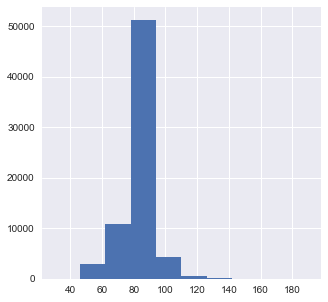

In [63]:
# ap_lo is right skewed as well, even more so than ap_hi, fix the same way, replace unrealistic values with median
lo_mean = np.mean(data_copy['ap_lo'])
lo_med = np.median(data_copy['ap_lo'])
print(lo_med, lo_mean)
# median < mean confirms right skew
data_copy.loc[data_copy['ap_lo'] > 190, 'ap_lo'] = lo_med
data_copy.loc[data_copy['ap_lo'] < 30, 'ap_lo'] = lo_med
np.sort(data_copy['ap_lo'])
c=data_copy['ap_lo'].hist(figsize=(5,5))
new_mean = np.mean(data_copy['ap_lo'])
new_med = np.median(data_copy['ap_lo'])
print(new_mean, new_med)
# ap_lo didn't need much normalizing but at least absurd values are gone

72.0 74.20569
74.23399785714287 72.0


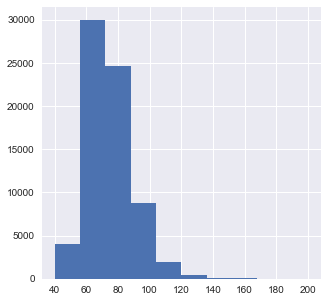

In [64]:
# now to fix the weights, looks a bit right skewed but will check mean and med to confirm
weight_mean = np.mean(data_copy['weight'])
weight_med = np.median(data_copy['weight'])
print(weight_med, weight_mean)
# median < mean confirms right skew, even if just barely, replace invalid values with median
data_copy.loc[data_copy['weight'] < 40, 'weight'] = weight_med
np.sort(data_copy['weight'])
c=data_copy['weight'].hist(figsize=(5,5))
new_mean = np.mean(data_copy['weight'])
new_med = np.median(data_copy['weight'])
print(new_mean, new_med)
# weight didn't need much normalizing either, but again, outlandish values are gone now

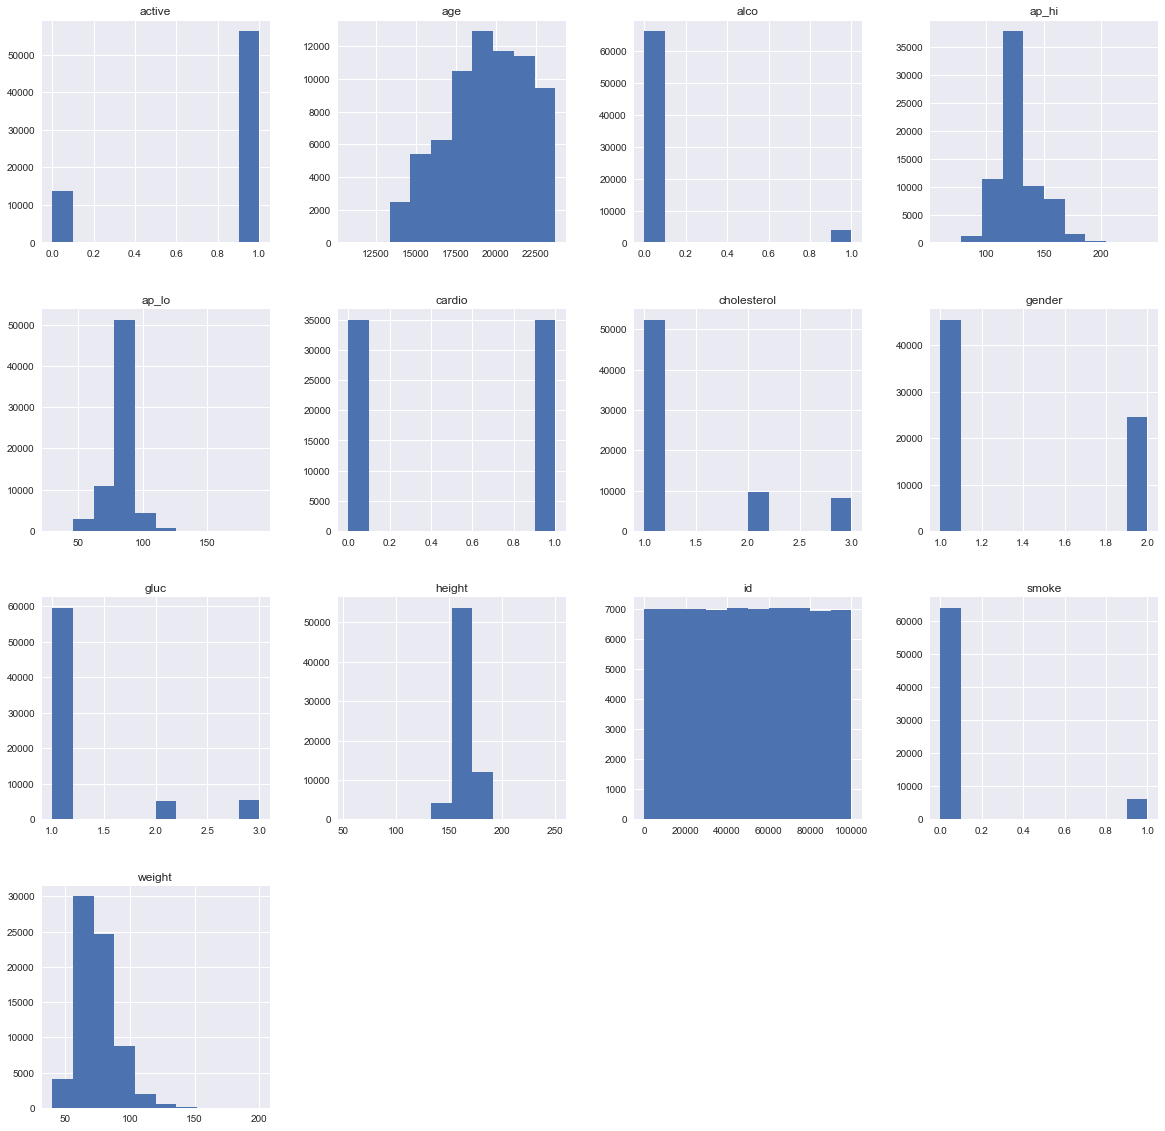

In [65]:
p = data_copy.hist(figsize = (20,20))

0    35021
1    34979
Name: cardio, dtype: int64


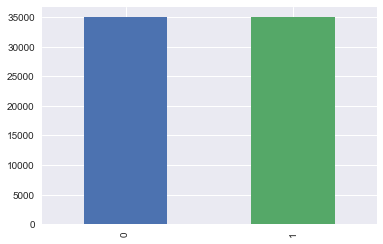

In [66]:
# check cardio data to check for bias in outcome
color_wheel = {0: "#0000ff", 
               1: "#ff0000"}
colors = data["cardio"].map(lambda x: color_wheel.get(x + 1))
print(data.cardio.value_counts())
p = data.cardio.value_counts().plot(kind="bar")
# no clear bias for results, pretty even split of patients with and without heart disease

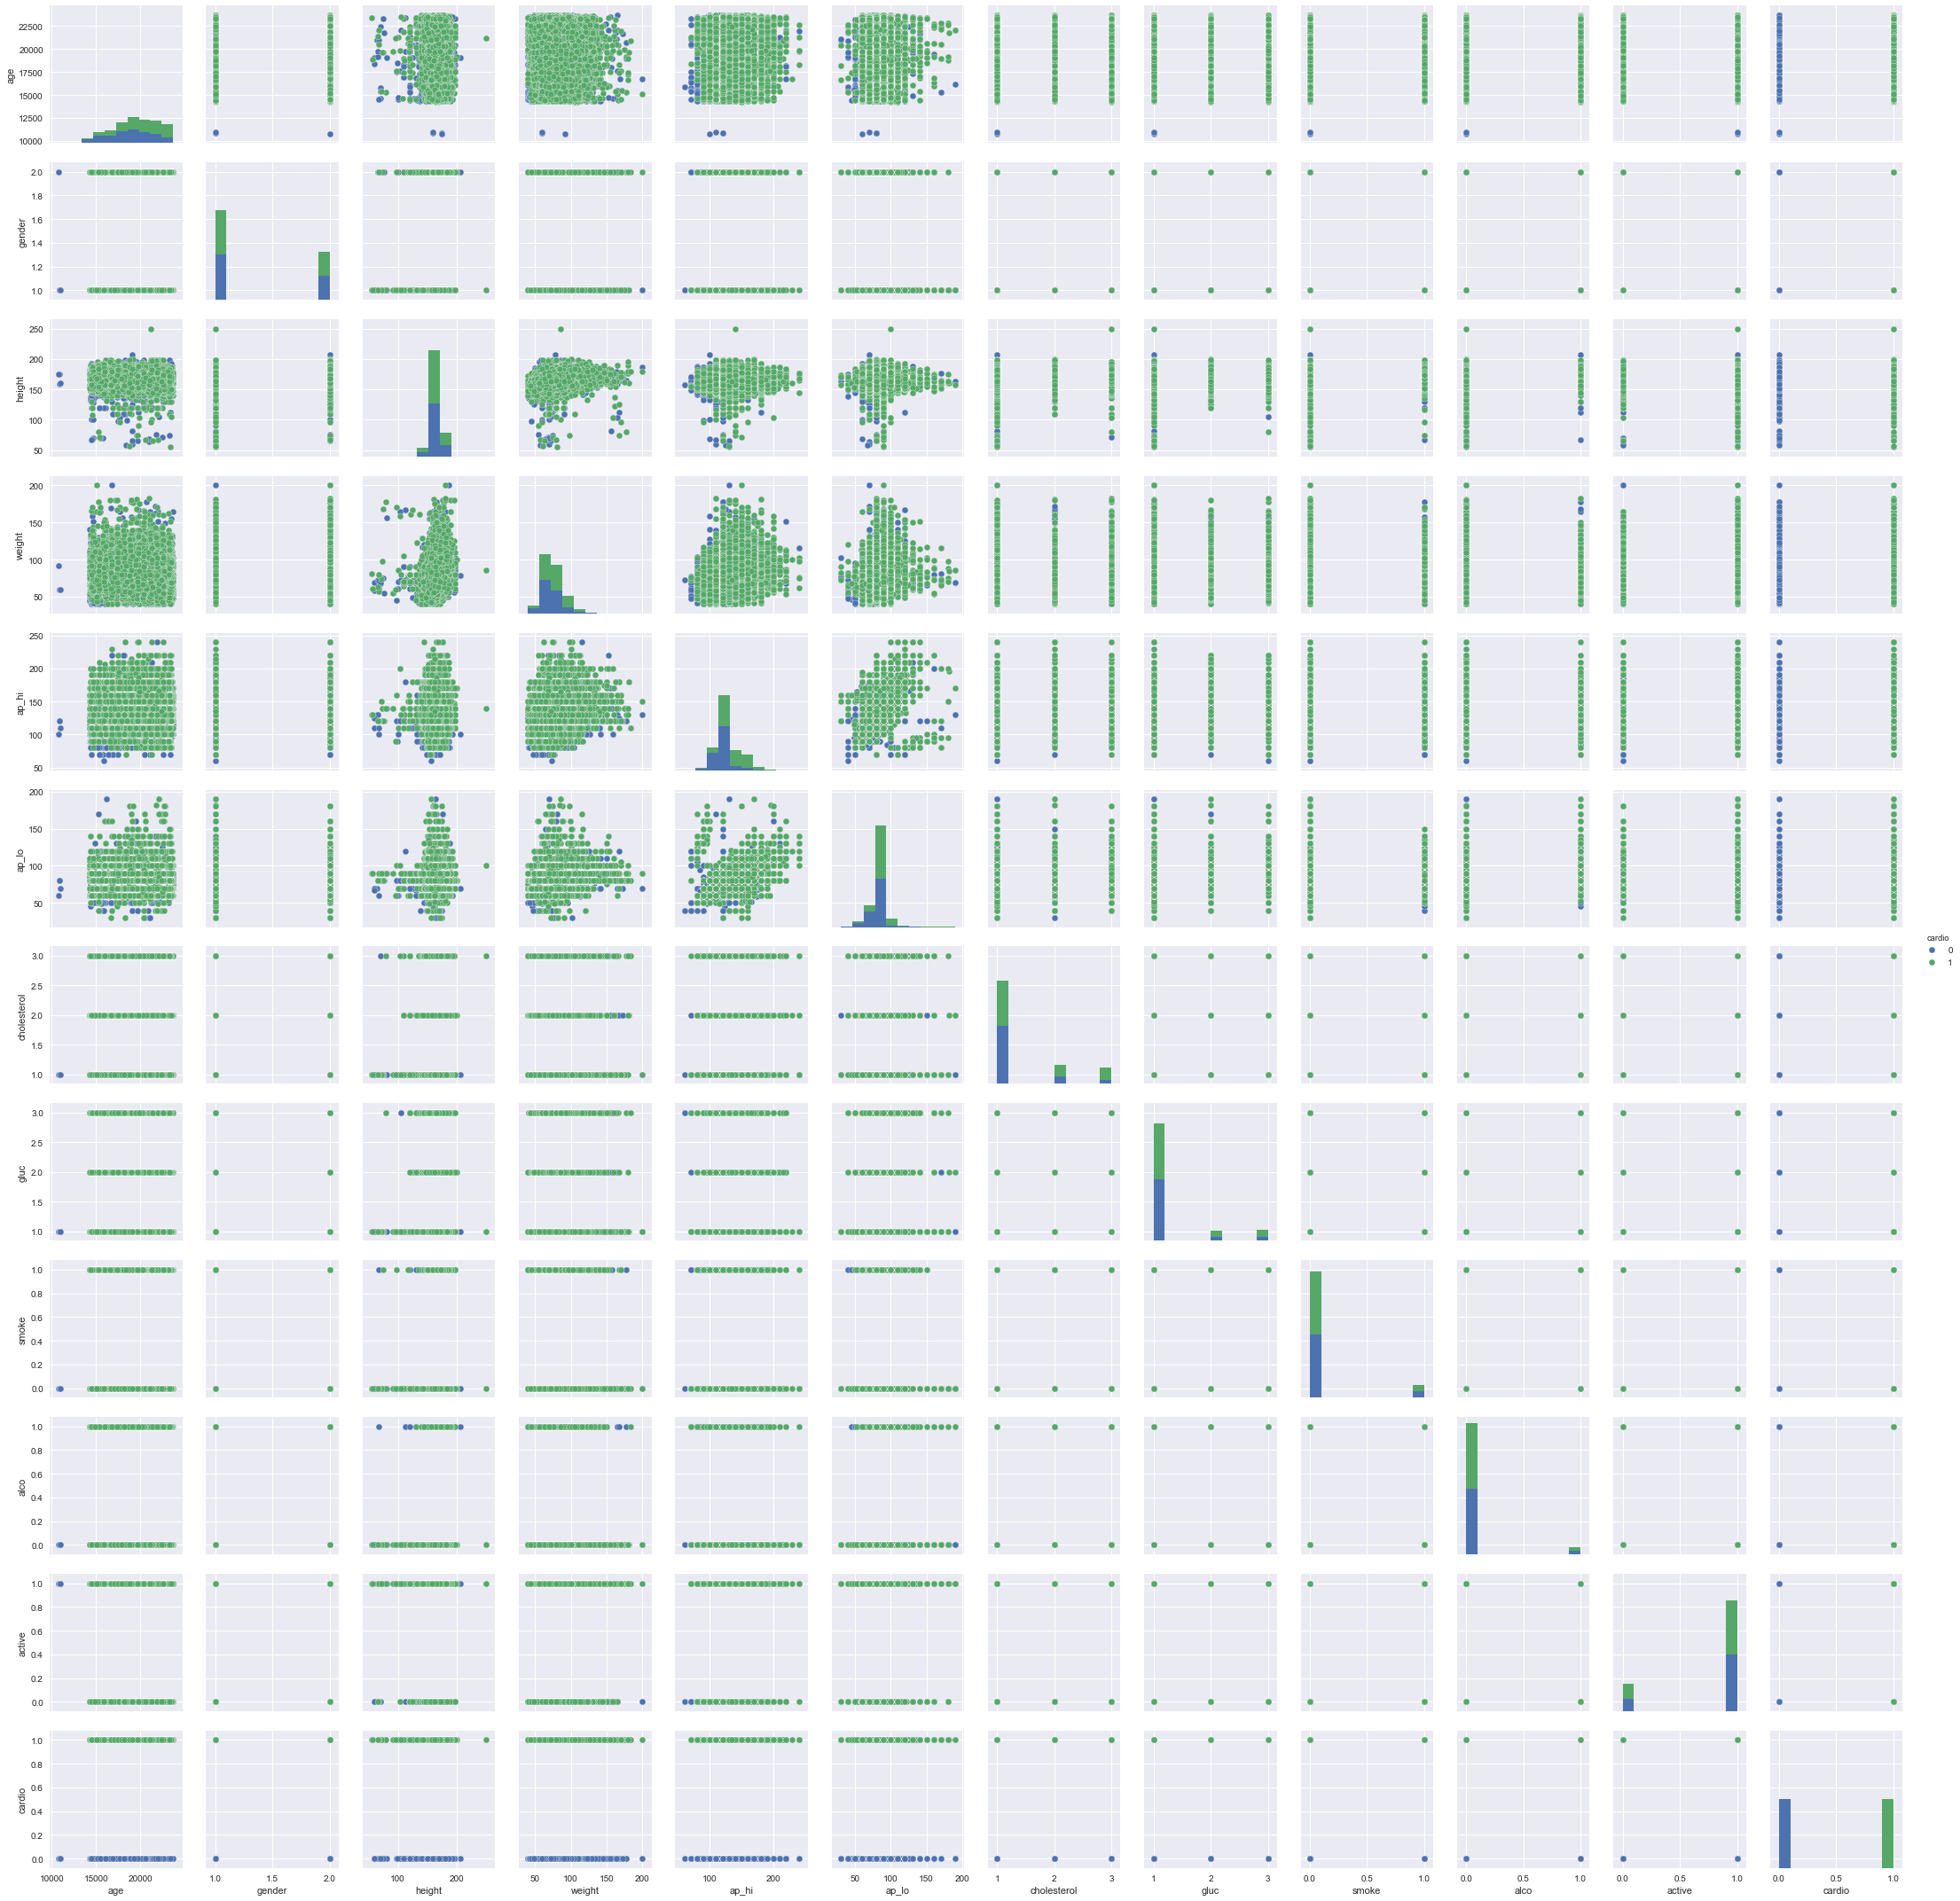

In [67]:
# pair plot for the clean data, finish cleaning by just dropping 'id' column as it has no relevance to results
del data_copy['id']
p = sns.pairplot(data_copy, hue = 'cardio')

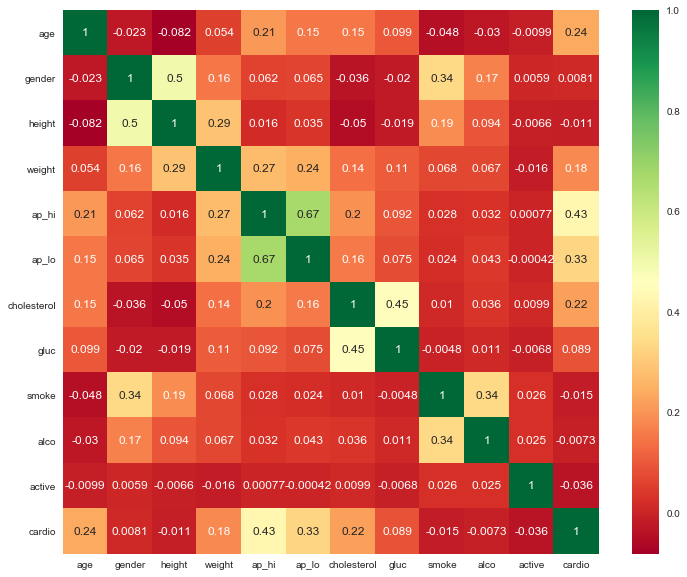

In [68]:
# heatmap of cleaned data to find any significant correlation by inspecting Pearson's coefficient btwn vars
plt.figure(figsize=(12,10))
p = sns.heatmap(data_copy.corr(), annot=True,cmap ='RdYlGn')
# decent correlation btwn the following values: height & gender, smoke & gender, ap_hi & ap_lo, cholesterol & glucose, ** ap_hi, ap_lo and cardio **

In [69]:
# scale data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(data_copy.drop(["cardio"],axis = 1),),
        columns=['age', 'gender', 'height', 'weight', 'ap_hi',
       'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'])


In [70]:
X.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,-0.436062,1.364055,0.443452,-0.852382,-0.994481,-0.141178,-0.539322,-0.39572,-0.310879,-0.238384,0.494167
1,0.307686,-0.733108,-1.018168,0.750102,0.762655,0.896722,2.400793,-0.39572,-0.310879,-0.238384,0.494167
2,-0.247997,-0.733108,0.078047,-0.713036,0.176943,-1.179079,2.400793,-0.39572,-0.310879,-0.238384,-2.023607
3,-0.748152,1.364055,0.565254,0.541083,1.348366,1.934623,-0.539322,-0.39572,-0.310879,-0.238384,0.494167
4,-0.808543,-0.733108,-1.018168,-1.270422,-1.580193,-2.216980,-0.539322,-0.39572,-0.310879,-0.238384,-2.023607


In [71]:
y = data_copy.cardio
# y.head()

In [72]:
# start test/train split and cross validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42, stratify=y) # random_state = 42 bc scikit documentation always uses it

In [73]:
# use k nearest neighbors algo
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1,20):

    knn = KNeighborsClassifier(i) # finds 1-20 nearest neighbors
    knn.fit(X_train,y_train) # fit data to output
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [74]:
# score from testing on same datapoints used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 99.98071401020015 % and k = [1]


In [75]:
# score for datapoints split for tetsing only
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))
# k = 17 gives the best result so we'll use 17 for the final model

Max test score 72.07508356904088 % and k = [17]


In [78]:
knn = KNeighborsClassifier(17) # knn classifier w 17 neighbors

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.7207508356904089

In [79]:
# analyze model performance w confusion matrix
from sklearn.metrics import confusion_matrix
# get predictions using classifier that was fit above
y_pred = knn.predict(X_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,8780,2894,11674
1,3622,8038,11660
All,12402,10932,23334


Text(0.5,16,'Predicted label')

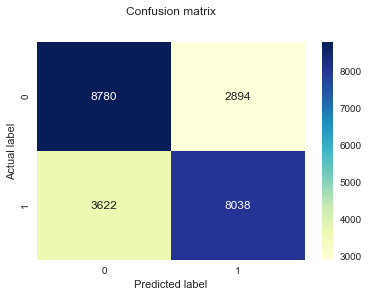

In [80]:
y_pred = knn.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [81]:
# classification report to find precision, recall and F1 score
# precision - ratio of correct positive predicted observations to total positive predicted observations
# recall - ratio of correctly predicted positive observations to all observations
# F1 score - weighted average of precision and recall, taking both false positives and false negatives into account
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.71      0.75      0.73     11674
          1       0.74      0.69      0.71     11660

avg / total       0.72      0.72      0.72     23334



In [82]:
# ROC curve to test classification performance => how well the model distinguishes btwn two things
#(whether patient has cardiac disease or not) good models can distinguish btwn the two better than bad models
from sklearn.metrics import roc_curve
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

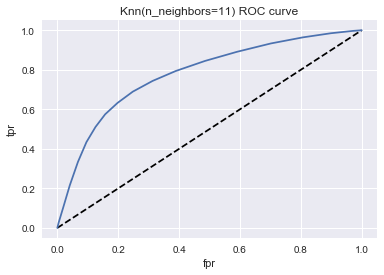

In [83]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=11) ROC curve')
plt.show()

In [84]:
# area under roc curve => roc auc score => closer to 1 the better the model is at distinguishing
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)
# score of .778 is pretty good, means there is a 77.8% chance the model will be able to distinguish btwn positive and negative cases

0.7780498129428667

In [85]:
# optimize hyper parameter with grid search 
# **** VERY COMPUTATIONALLY HEAVY, DONT RUN UNLESS YOU FEEL LIKE KILLING YOUR COMPUTER'S BATTERY *** #
from sklearn.model_selection import GridSearchCV
# going to tune n neighbors in knn classifier
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

KeyboardInterrupt: 